# Player detection Tennis

## Court detection

First we implement a code to detect the court lines.

We use the 2023 Wimbledon final between Djokovic and Alcaraz.

Frame shape: (720, 1280, 3)


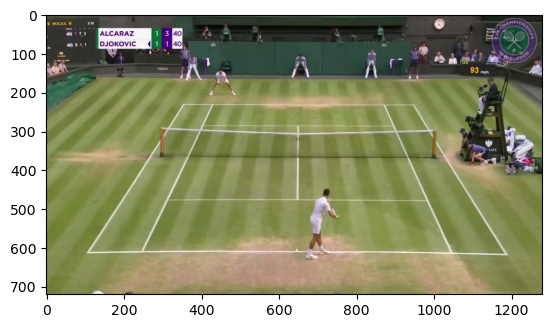

In [683]:
import cv2
import matplotlib.pyplot as plt

video_path = 'Alcaraz_Djokovic_Wimbledon_2023_Final.mp4'

cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)  # Get frames per second
frame_number = 10 * 60 * fps  # Calculate frame number for 20th minute

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)  # Set the position of the video file to the desired frame

ret, frame = cap.read()

frame_shape = frame.shape
print(f"Frame shape: {frame_shape}")
if ret:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert color space for matplotlib
    plt.imshow(frame)
    plt.show()
else:
    print("Couldn't retrieve frame.")

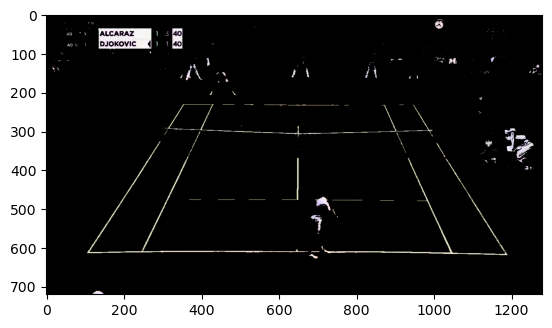

In [684]:
# Convertir l'image en niveaux de gris
gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Définir un seuil de luminosité pour déterminer les pixels blancs
seuil = 200

# Créer un masque pour les pixels suffisamment blancs
mask = cv2.threshold(gray_image, seuil, 255, cv2.THRESH_BINARY)[1]

# Appliquer le masque à l'image d'origine
result = cv2.bitwise_and(frame, frame, mask=mask)

plt.imshow(result)

In [685]:
import numpy as np

def detect_lines(image, tau, threshold):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Initialize an empty image to store the result
    result = np.zeros_like(gray)
    
    # Loop through each pixel in the image
    for i in range(len(gray)):
        for j in range(len(gray[0])):
            pixel_intensity = gray[i, j]
            
            # Check if the pixel belongs to a vertical line
            if j + tau < len(gray[0]) and j - tau >= 0:
                if (pixel_intensity - gray[i, j + tau] > threshold) and (pixel_intensity - gray[i, j - tau] > threshold):
                    result[i, j] = 255
            # Check if the pixel belongs to a horizontal line
            if i + tau < len(gray) and i - tau >= 0:
                if (pixel_intensity - gray[i + tau, j] > threshold) and (pixel_intensity - gray[i - tau, j] > threshold):
                    result[i, j] = 255
                    
    return result

C:\Users\marin\AppData\Local\Temp\ipykernel_12180\1804313923.py:21: RuntimeWarning: overflow encountered in scalar subtract
  if (pixel_intensity - gray[i + tau, j] > threshold) and (pixel_intensity - gray[i - tau, j] > threshold):
C:\Users\marin\AppData\Local\Temp\ipykernel_12180\1804313923.py:17: RuntimeWarning: overflow encountered in scalar subtract
  if (pixel_intensity - gray[i, j + tau] > threshold) and (pixel_intensity - gray[i, j - tau] > threshold):


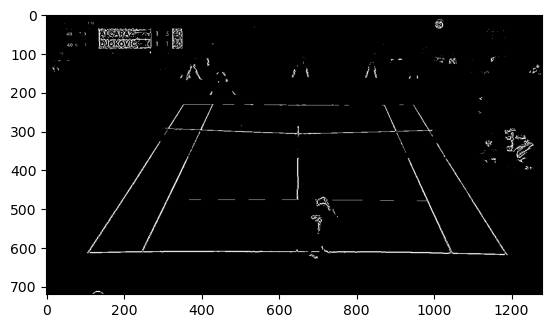

In [686]:
update_result = detect_lines(result, 3, 100)
plt.imshow(update_result, cmap='gray')

## Line detection

27


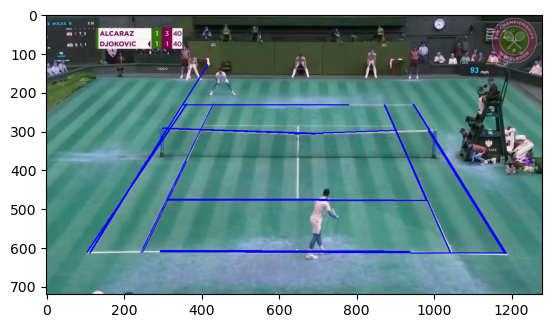

In [687]:
edges = cv2.Canny(update_result, 50, 150, apertureSize=3)

# Apply Probabilistic Hough Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 90, 100, minLineLength=200, maxLineGap=80)

# Create a copy of the original image to draw lines on
line_image = np.copy(frame)

# Draw each line
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Convert color space for matplotlib
line_image = cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)

print(len(lines))
plt.imshow(line_image)
plt.show()

### Horizontal, left-vertical and right-vertical lines

In [688]:
def line_classification(lines, frame_shape):
    left_vertical_lines = []
    right_vertical_lines = []
    horizontal_lines = []
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dx = np.abs(x2 - x1)
        dy = np.abs(y2 - y1)
        if dx < dy:
            if min(x1, x2) < frame_shape[1] / 3:
                left_vertical_lines.append(line)
            elif max(x1, x2) > 2 * frame_shape[1] / 3:
                right_vertical_lines.append(line)
        else:
            horizontal_lines.append(line)
            
    return left_vertical_lines, right_vertical_lines, horizontal_lines

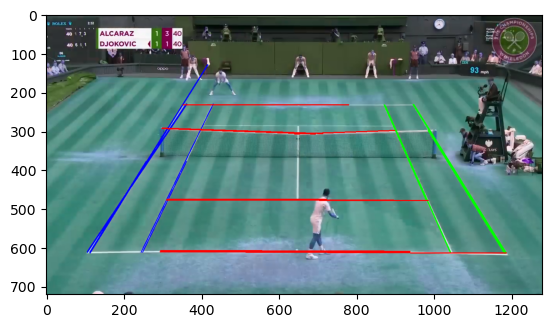

In [689]:
def draw_lines(image, lines, color):
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), color, 2)

# Assuming 'lines' is the output of cv2.HoughLinesP()
left_vertical_lines, right_vertical_lines, horizontal_lines = line_classification(lines, frame.shape)

# Create a copy of the original image to draw lines on
line_image = np.copy(frame)

# Draw lines on the image
draw_lines(line_image, left_vertical_lines, (255, 0, 0))  # Red for left vertical lines
draw_lines(line_image, right_vertical_lines, (0, 255, 0))  # Green for right vertical lines
draw_lines(line_image, horizontal_lines, (0, 0, 255))  # Blue for horizontal lines

# Convert color space for matplotlib
line_image = cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)

plt.imshow(line_image)
plt.show()

### Merging lines

In [690]:
  
def leftmost_point_sort(lines):
    lines_sorted = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x1 < x2:
            lines_sorted.append(np.array([[x1, y1, x2, y2]]))
        else:
            lines_sorted.append(np.array([[x2, y2, x1, y1]]))
    return lines_sorted

def angle_between_lines(line1, line2):
    x1, y1, x2, y2 = line1[0]
    x3, y3, x4, y4 = line2[0]

    # Calculate the direction of each line
    direction1 = np.array([x2 - x1, y2 - y1])
    direction2 = np.array([x4 - x3, y4 - y3])

    # Calculate the unit direction of each line
    unit_direction1 = direction1 / np.linalg.norm(direction1)
    unit_direction2 = direction2 / np.linalg.norm(direction2)

    # Calculate the angle between the two lines
    dot_product = np.dot(unit_direction1, unit_direction2)
    angle = np.arccos(dot_product)

    return np.degrees(angle)

def merge_horizontal_lines(lines, threshold=15):
    
    print(lines)
    lines = leftmost_point_sort(lines)
    print(lines)
    
    merged = False

    while not merged:
        #Tant qu'on peut merger des lignes
        merged_lines = []
        merged = True
        
        while len(lines) > 1:
            # Si il y a au moins 2 lignes à merger
            line_a = lines[0]
            i = 1
            print(f"Len lines: {len(lines)}")
            pair_merged = False
            while i <= len(lines) - 1:
                # Pour chaque ligne, on regarde si on peut la merger avec la première
                print(f"test merge ligne 0 et {i}")
                line_b = lines[i]  

                # La ligne L est la ligne la plus à gauche
                if line_a[0][0] < line_b[0][0]:
                    L = line_a
                    R = line_b
                else:
                    L = line_b
                    R = line_a
                
                # On calcule la distance entre les deux lignes
                d = abs(L[0][3] - R[0][1])
                print(f"distance {d}")
 
                if d < threshold:
                    angle = angle_between_lines(L, R)
                    if angle < 1:
                        # Si on peut merger les lignes
                        print("Lignes mergees")
                        
                        # On crée la ligne mergee
                        M = np.array([[L[0][0], L[0][1], R[0][2], R[0][3]]])
                        
                        # On ajoute la ligne mergee à merged_lines
                        merged_lines.append(M)
                        print(merged_lines)
                        
                        # On supprime les lignes de L et R de lines
                        lines.pop(0)
                        lines.pop(i-1)
                        print(f"lignes pop : 0 et {i}")
                        print(lines)
                        
                        merged = False
                        pair_merged = True
                        # On sort de la boucle
                        break
                    else:
                        # Si on ne peut pas merger les lignes on passe à la suivante
                        print("lignes non mergees")
                        i += 1
                else:
                    # Si on ne peut pas merger les lignes on passe à la suivante
                    print("lignes non mergees")
                    i += 1
            if not pair_merged:
                # Si on a parcouru toutes les lignes et qu'on a pas pu merger la première ligne avec une autre
                # On ajoute la première ligne à merged_lines et on la supprime de lines
                print(f"Ajout de la ligne {lines[0]}")
                merged_lines.append(lines[0])
                lines.pop(0)
                print("ligne pop 0")
            
        if len(lines) == 1:
            # Si il reste une seule ligne à la fin on l'ajoute à merged_lines
            print(f"ligne restante : {lines[0]}")
            merged_lines.append(lines[0])
            lines.pop(0)
            print("-----------------")
        lines = merged_lines
        print(lines)
        print(f"Merged : {merged}")


    return merged_lines

# Assuming 'horizontal_lines' is the list of horizontal lines
merged_horizontal_lines = merge_horizontal_lines(horizontal_lines)
print(merged_horizontal_lines)
print(len(merged_horizontal_lines))



[array([[515, 609, 872, 609]], dtype=int32), array([[294, 611, 730, 611]], dtype=int32), array([[515, 612, 872, 612]], dtype=int32), array([[299, 294, 695, 308]], dtype=int32), array([[353, 233, 781, 233]], dtype=int32), array([[295, 608, 557, 608]], dtype=int32), array([[310, 478, 897, 478]], dtype=int32), array([[312, 476, 724, 476]], dtype=int32), array([[726, 613, 939, 613]], dtype=int32), array([[299, 293, 714, 307]], dtype=int32), array([[648, 610, 939, 610]], dtype=int32), array([[ 940,  614, 1188,  614]], dtype=int32), array([[641, 308, 900, 299]], dtype=int32), array([[705, 479, 986, 479]], dtype=int32)]
[array([[515, 609, 872, 609]], dtype=int32), array([[294, 611, 730, 611]], dtype=int32), array([[515, 612, 872, 612]], dtype=int32), array([[299, 294, 695, 308]], dtype=int32), array([[353, 233, 781, 233]], dtype=int32), array([[295, 608, 557, 608]], dtype=int32), array([[310, 478, 897, 478]], dtype=int32), array([[312, 476, 724, 476]], dtype=int32), array([[726, 613, 939, 613

In [ ]:
def leftmost_point_sort(lines):
    lines_sorted = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x1 < x2:
            lines_sorted.append(np.array([[x1, y1, x2, y2]]))
        else:
            lines_sorted.append(np.array([[x2, y2, x1, y1]]))
    return lines_sorted

def angle_between_lines(line1, line2):
    x1, y1, x2, y2 = line1[0]
    x3, y3, x4, y4 = line2[0]

    # Calculate the direction of each line
    direction1 = np.array([x2 - x1, y2 - y1])
    direction2 = np.array([x4 - x3, y4 - y3])

    # Calculate the unit direction of each line
    unit_direction1 = direction1 / np.linalg.norm(direction1)
    unit_direction2 = direction2 / np.linalg.norm(direction2)

    # Calculate the angle between the two lines
    dot_product = np.dot(unit_direction1, unit_direction2)
    angle = np.arccos(dot_product)

    return np.degrees(angle)

def merge_horizontal_lines(lines, threshold=15):
    
    print(lines)
    lines = leftmost_point_sort(lines)
    print(lines)
    
    merged = False

    while not merged:
        #Tant qu'on peut merger des lignes
        merged_lines = []
        merged = True
        
        while len(lines) > 1:
            # Si il y a au moins 2 lignes à merger
            line_a = lines[0]
            i = 1
            print(f"Len lines: {len(lines)}")
            pair_merged = False
            while i <= len(lines) - 1:
                # Pour chaque ligne, on regarde si on peut la merger avec la première
                print(f"test merge ligne 0 et {i}")
                line_b = lines[i]  

                # La ligne L est la ligne la plus à gauche
                if line_a[0][0] < line_b[0][0]:
                    L = line_a
                    R = line_b
                else:
                    L = line_b
                    R = line_a
                
                # On calcule la distance entre les deux lignes
                d = abs(L[0][3] - R[0][1])
                print(f"distance {d}")
 
                if d < threshold:
                    angle = angle_between_lines(L, R)
                    if angle < 1:
                        # Si on peut merger les lignes
                        print("Lignes mergees")
                        
                        # On crée la ligne mergee
                        M = np.array([[L[0][0], L[0][1], R[0][2], R[0][3]]])
                        
                        # On ajoute la ligne mergee à merged_lines
                        merged_lines.append(M)
                        print(merged_lines)
                        
                        # On supprime les lignes de L et R de lines
                        lines.pop(0)
                        lines.pop(i-1)
                        print(f"lignes pop : 0 et {i}")
                        print(lines)
                        
                        merged = False
                        pair_merged = True
                        # On sort de la boucle
                        break
                    else:
                        # Si on ne peut pas merger les lignes on passe à la suivante
                        print("lignes non mergees")
                        i += 1
                else:
                    # Si on ne peut pas merger les lignes on passe à la suivante
                    print("lignes non mergees")
                    i += 1
            if not pair_merged:
                # Si on a parcouru toutes les lignes et qu'on a pas pu merger la première ligne avec une autre
                # On ajoute la première ligne à merged_lines et on la supprime de lines
                print(f"Ajout de la ligne {lines[0]}")
                merged_lines.append(lines[0])
                lines.pop(0)
                print("ligne pop 0")
            
        if len(lines) == 1:
            # Si il reste une seule ligne à la fin on l'ajoute à merged_lines
            print(f"ligne restante : {lines[0]}")
            merged_lines.append(lines[0])
            lines.pop(0)
            print("-----------------")
        lines = merged_lines
        print(lines)
        print(f"Merged : {merged}")


    return merged_lines

# Assuming 'horizontal_lines' is the list of horizontal lines
merged_horizontal_lines = merge_horizontal_lines(horizontal_lines)
print(merged_horizontal_lines)
print(len(merged_horizontal_lines))


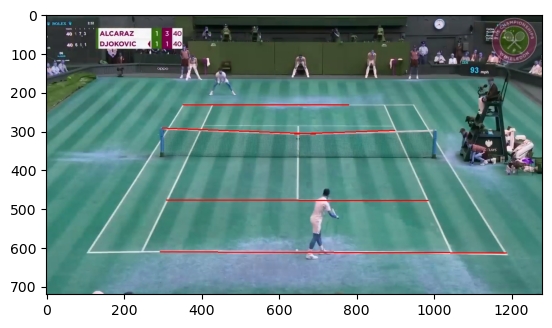

In [691]:
# Draw merged lines on the image
line_image = np.copy(frame)
draw_lines(line_image, merged_horizontal_lines, (0, 0, 255))  # Blue for merged horizontal lines

# Convert color space for matplotlib
line_image = cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)

plt.imshow(line_image)
plt.show()

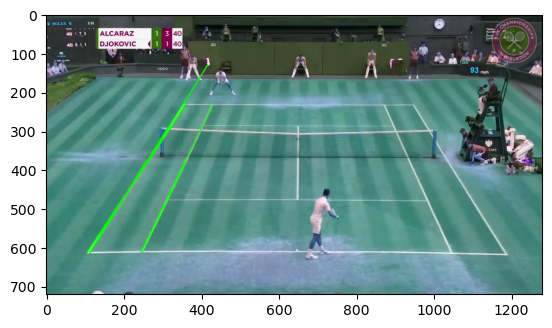

In [692]:
def merge_vertical_lines(lines, threshold=10):
    # Sort lines by the y-coordinate of the first point
    lines.sort(key=lambda line: line[0][1])

    merged_lines = []
    for i in range(len(lines) - 1):
        T = lines[i]
        B = lines[i + 1]

        # Calculate the difference in x-coordinates
        d = abs(T[0][2] - B[0][0])

        if d < threshold:
            # Merge lines
            M = [[T[0][0], T[0][1], B[0][2], B[0][3]]]
            merged_lines.append(M)
        else:
            merged_lines.append(T)

    # Add the last line
    if len(lines) > 0:
        merged_lines.append(lines[-1])

    return merged_lines

# Assuming 'vertical_lines' is the list of vertical lines
merged_vertical_lines = merge_vertical_lines(left_vertical_lines)

# Draw merged lines on the image
line_image = np.copy(frame)
draw_lines(line_image, merged_vertical_lines, (0, 255, 0))  # Green for merged vertical lines

# Convert color space for matplotlib
line_image = cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)

plt.imshow(line_image)
plt.show()